# Good Bad Image Selection

In [1]:
import os
import multiprocessing
import numpy as np
import pandas as pd
import xml.etree.ElementTree as ET

from matplotlib import pyplot as plt
from matplotlib.cm import ScalarMappable as mpl_scalar_mappale
from matplotlib.colors import Normalize as mpl_norm
from matplotlib_scalebar.scalebar import ScaleBar
from PIL import Image
from pathlib import Path 
from functools import partial
from tqdm.auto import tqdm

In [2]:
def accuracy(gt_array, pred_array):
    return np.mean(gt_array==pred_array)

def dice(gt_array, pred_array, label):
    gt_array, pred_array = (gt_array == label).astype('float'), (pred_array == label).astype('float')
    intersection = np.sum(gt_array * pred_array)
    union = np.sum(gt_array + pred_array)
    union = 1 if union == 0 else union
    return 2*intersection / union

def label_count(pred_array, label):
    return np.sum(pred_array == label)

def multiprocess(function, iterable, **kwargs):
    one_arg_fnx = partial(function, **kwargs)
    cpus = multiprocessing.cpu_count()
    results = []
    with multiprocessing.Pool(processes=cpus) as pool:
        for r in tqdm(pool.imap(one_arg_fnx, iterable), total=len(iterable)):
            results.append(r)
    return results

def walk_directory_to_file_list(directory, condition_function=lambda x: True):
    file_list = []
    for root, dirs, files in os.walk(directory):    
        for file in files:
            if condition_function(file):
                file_list.append(os.path.join(root, file))
    return file_list

def calculate_results(gt, pred_dir=None, model_name=None):
    
    gt_path = Path(gt)
    gt = np.array(Image.open(gt_path))
    pred_path = Path(pred_dir) / Path(gt_path).name
    pred = np.array(Image.open(pred_path))
    
    out_dict = {}
    out_dict['id'] = gt_path.stem
    out_dict['model_name'] = model_name
    out_dict['gt_path'] = gt_path
    out_dict['pred_path'] = pred_path
    
    out_dict['gt_background_pixels'] = label_count(gt, 0)
    out_dict['gt_plaque_pixels'] = label_count(gt, 1)
    out_dict['gt_lumen_pixels'] = label_count(gt, 2)
    out_dict['gt_occlusion_fraction'] = out_dict['gt_plaque_pixels'] / (out_dict['gt_plaque_pixels'] + out_dict['gt_lumen_pixels'])
    
    out_dict['pred_background_pixels'] = label_count(pred, 0)
    out_dict['pred_plaque_pixels'] = label_count(pred, 1)
    out_dict['pred_lumen_pixels'] = label_count(pred, 2)
    out_dict['pred_occlusion_fraction'] = out_dict['pred_plaque_pixels'] / (out_dict['pred_plaque_pixels'] + out_dict['pred_lumen_pixels'])
    
    out_dict['plaque_dice'] = dice(gt, pred, 1)
    out_dict['lumen_dice'] = dice(gt, pred, 2)
    out_dict['accuracy'] = accuracy(gt, pred)
    
    return out_dict  

def get_overlay_image(img_path, msk_path, num_labels=3):
    
    labels = np.array(PILImage.open(msk_path))
    
    sm = mpl_scalar_mappale(mpl_norm(0, num_labels-1), 'viridis')
    cm_arr_rgba = sm.to_rgba(labels)
    cm_arr_rgba = (cm_arr_rgba * 255).astype('uint8')
    cm_arr_rbga_img = PILImage.fromarray(cm_arr_rgba, mode='RGBA')

    img_arr_rgb = np.array(PILImage.open(img_path))
    alpha_channel = np.full((512, 512, 1), 255, dtype='uint8')
    img_arr_rgba = np.concatenate((img_arr_rgb, alpha_channel), axis=-1).astype('uint8')
    img_arr_rgba_img = PILImage.fromarray(img_arr_rgba, mode='RGBA')

    ol_img = PILImage.blend(img_arr_rgba_img, cm_arr_rbga_img, 0.3)
    
    return ol_img

def img_dim_from_metadata_xml(metadata_xml):

    requested_attributes = [
        'PhysicalSizeX',
        'PhysicalSizeY',
        'PhysicalSizeXUnit',
        'PhysicalSizeYUnit',
        'SizeX',
        'SizeY'
    ]

    ns = {'ome': 'http://www.openmicroscopy.org/Schemas/OME/2016-06'}

    tree = ET.parse(metadata_xml)
    elem = tree.find(".//ome:Image[@ID='Image:0']/ome:Pixels", ns)

    return_dict = dict()

    for a in requested_attributes:
        return_dict[a] = elem.get(a)

    return return_dict



In [3]:
pred_dir = '/data/jacob/vesseg/data/predictions/{}/'
gt_dir = '/data/jacob/vesseg/data/resized/masks/'
models = ['nnunet', 'fastai']
results = []
l = walk_directory_to_file_list(gt_dir, lambda x: x.endswith('.png'))

for m in models:
    results += multiprocess(calculate_results, l, pred_dir=pred_dir.format(m), model_name=m)
 
df = pd.DataFrame(results)

In [123]:
# First mechanism to determine percentiles for average accuracy
perc_choose = df[['accuracy', 'id']].groupby('id').mean()
perc_choose = perc_choose.reset_index()

q0010 = perc_choose[perc_choose['accuracy']<=perc_choose.quantile(0.1)['accuracy']]
q4555 = perc_choose[(perc_choose['accuracy']>perc_choose.quantile(0.45)['accuracy'])&(perc_choose['accuracy']<=perc_choose.quantile(0.55)['accuracy'])]
q9010 = perc_choose[perc_choose['accuracy']>perc_choose.quantile(0.9)['accuracy']]

ids = [df['id'].sample(n=1).values[0] for df in [q0010, q4555, q9010]]

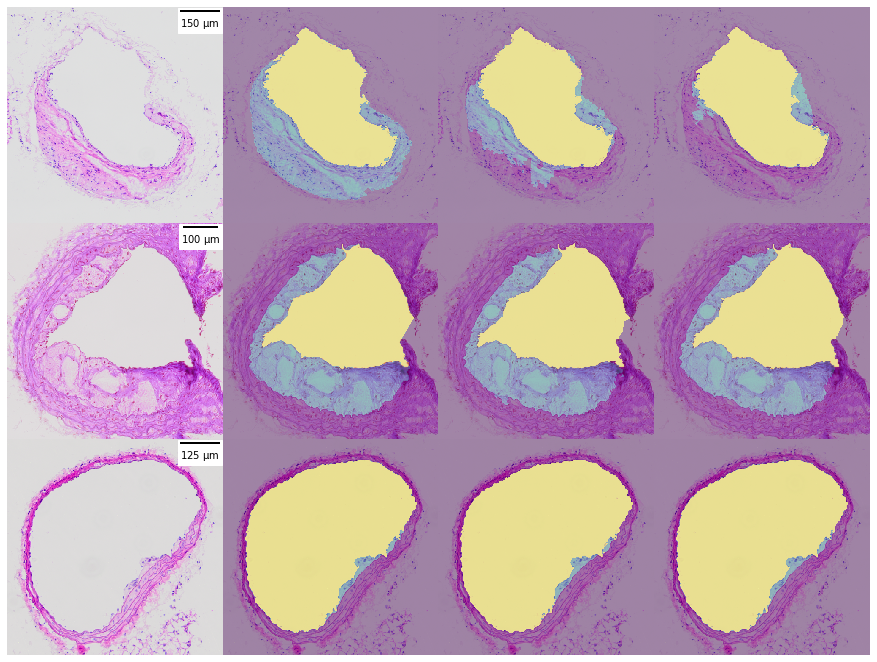

In [169]:
# Create complete image
ids = ['18_135_OT31_4', '18_94_OT46_HE_20181001_04', '18_28_OT16_4']
gt_img_dir = '/data/jacob/vesseg/data/resized/images/'
gt_msk_dir = '/data/jacob/vesseg/data/resized/masks/'
pred_nnunet_dir = '/data/jacob/vesseg/data/predictions/nnunet/'
pred_fastai_dir = '/data/jacob/vesseg/data/predictions/fastai/'
cp_img_dir ='/data/jacob/vesseg/data/cropped/masks/'
meta_dir = '/data/jacob/vesseg/data/original/images/metadata/'

fig, axs = plt.subplots(3,4, figsize=(12,9))

for e, i in enumerate(ids):
    
        # image
        axs[e, 0].imshow(np.array(Image.open(os.path.join(gt_img_dir, i + '.png'))))
        img = Image.open(os.path.join(cp_img_dir, i + '.png'))
        meta = img_dim_from_metadata_xml(os.path.join(meta_dir, i + '.xml'))
        w = img.info['crop_dim_y']
        p = meta['PhysicalSizeX']
        resize_factor = int(w)/512
        p_resized = float(p) * resize_factor
        scalebar = ScaleBar(p_resized, 'um')
        axs[e,0].add_artist(scalebar)
        
        # ground truth 
        axs[e, 1].imshow(np.array(Image.open(os.path.join(gt_img_dir, i + '.png'))))
        axs[e, 1].imshow(np.array(Image.open(os.path.join(gt_msk_dir, i + '.png'))), alpha=0.4)
        
        # fastai
        axs[e, 2].imshow(np.array(Image.open(os.path.join(gt_img_dir, i + '.png'))))
        axs[e, 2].imshow(np.array(Image.open(os.path.join(pred_fastai_dir, i + '.png'))), alpha=0.4)
        
        # nnunet
        axs[e, 3].imshow(np.array(Image.open(os.path.join(gt_img_dir, i + '.png'))))
        axs[e, 3].imshow(np.array(Image.open(os.path.join(pred_nnunet_dir, i + '.png'))), alpha=0.4)

        for j in range(4):
            axs[e, j].set_xticklabels([])
            axs[e, j].set_yticklabels([])
            axs[e, j].axis('off')
            axs[e, j].margins(0,0)
            axs[e, j].set_aspect('equal')



fig.tight_layout(pad=0)
fig.show()

fig.savefig('good_bad.png', bbox_inches='tight', dpi=1200, pad_inches=0)
    